# Lesson 7: Linear Regression

Fit a linear model to the Leinhardt dataset to find the corrilation between country income and infant mortatlity

This follows lessons here:
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/z1Aap/setup-in-r
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/fZngw/jags-model-linear-regression
 - https://www.coursera.org/learn/mcmc-bayesian-statistics/lecture/pAJNW/model-checking

In [50]:
# Download the data from here: 
# https://cran.r-project.org/web/packages/carData/index.html

# read in R data files
# https://github.com/ofajardo/pyreadr
import pyreadr

result = pyreadr.read_r('./data/Leinhardt.rda')
df = result['Leinhardt']
df.dropna(inplace=True)

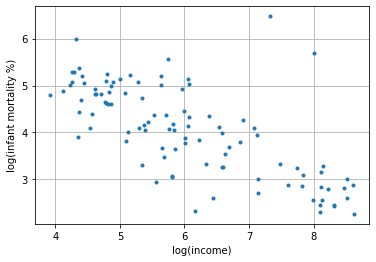

In [3]:
log_infant = np.log(df.infant.values)
log_income = np.log(df.income.values)
plt.plot(log_income, log_infant, '.')
plt.xlabel('log(income)')
plt.ylabel('log(infant mortality %)')

plt.grid(b='both', which='both');

## Modeling

### Linear model

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
lmod = LinearRegression().fit(log_infant.reshape(-1, 1), log_income.reshape(-1, 1))

In [6]:
r_sqd = lmod.score(log_infant.reshape(-1, 1), log_income.reshape(-1, 1))

In [7]:
lmod.intercept_

array([10.01518246])

In [8]:
lmod.coef_

array([[-0.98110443]])

In [9]:
r_sqd

0.50212361972335

### Baysean Monte Carlo

In [25]:
from jax import random
import jax.numpy as np  # We need the CUDA mirror of numpy (even if we're on a CPU)

import numpyro
import numpyro.diagnostics as diag
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

numpyro.set_host_device_count(3)  # Run mcmc in parallel
numpyro.enable_validation()  # Let pyro alert me to potential problems

In [26]:
def mod1(log_income, log_infant):
    # define priors
    b1 = numpyro.sample('b1', dist.Normal(0, 1e6))
    b2 = numpyro.sample('b2', dist.Normal(0, 1e6))

    std2 = numpyro.sample('std2', dist.InverseGamma(2.5, 2.5 * 10))
    std = np.sqrt(std2)

    # define liklihood
    mu = b1 + b2*log_income
    y = numpyro.sample('y', dist.Normal(mu, std), obs=log_infant)

In [27]:
num_warmup, num_samples = 1000, 5000
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

In [28]:
kernel = NUTS(mod1)
mcmc = MCMC(kernel, num_warmup, num_samples, num_chains=3)
mcmc.run(rng_key, collect_warmup=False, log_income=log_income, log_infant=log_infant, )
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b1      7.15      0.44      7.15      6.42      7.85   4563.30      1.00
        b2     -0.51      0.07     -0.51     -0.63     -0.40   4580.29      1.00
      std2      0.95      0.13      0.94      0.73      1.16   6255.94      1.00

Number of divergences: 0


In [29]:
samples_1 = mcmc.get_samples()

In [30]:
mod1_b1 = samples_1['b1'].reshape(3, -1)
mod1_b2 = samples_1['b2'].reshape(3, -1)
mod1_std2 = samples_1['std2'].reshape(3, -1)

Text(0, 0.5, 'std2')

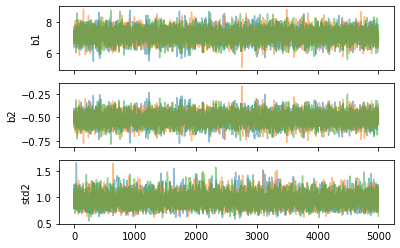

In [31]:
fig, axs = plt.subplots(3, 1, sharex=True)
[axs[0].plot(chain, alpha=.5) for chain in mod1_b1]
axs[0].set_ylabel('b1')
[axs[1].plot(chain, alpha=.5) for chain in mod1_b2]
axs[1].set_ylabel('b2')
[axs[2].plot(chain, alpha=.5) for chain in mod1_std2]
axs[2].set_ylabel('std2');

## Convergence

In [32]:
diag.gelman_rubin(mod1_b1)

1.0001884

In [33]:
diag.gelman_rubin(mod1_b2)

1.0001829

In [34]:
diag.gelman_rubin(mod1_std2)

1.0001044

### Auto Correlation

In [60]:
lag_idx = [0, 1, 5, 10, 50]

In [66]:
diag.autocorrelation(mod1_b1, axis=1)[:, lag_idx]

array([[ 1.00000000e+00,  4.91611880e-01,  5.76008523e-02,
         6.19998225e-04,  1.37903767e-02],
       [ 1.00000000e+00,  5.19166369e-01,  2.34235932e-02,
        -1.31431015e-02, -4.45653492e-02],
       [ 1.00000000e+00,  5.54168135e-01,  4.53391732e-02,
        -1.16576768e-02, -5.35732124e-03]])

In [65]:
diag.autocorrelation(mod1_b2, axis=1)[:, lag_idx]

array([[ 1.        ,  0.49183176,  0.05787461,  0.00667721,  0.01946086],
       [ 1.        ,  0.51600162,  0.02232307, -0.01927623, -0.04279028],
       [ 1.        ,  0.55391024,  0.04161856, -0.01011605, -0.00255354]])

In [64]:
diag.autocorrelation(mod1_std2, axis=1)[:, lag_idx]

array([[ 1.        ,  0.45362977,  0.03945353, -0.00852252, -0.01116697],
       [ 1.        ,  0.39714965, -0.01105182, -0.00485601, -0.01181986],
       [ 1.        ,  0.33388487,  0.02349229, -0.02146206, -0.02071139]])

### Effective sample

Effective sample size appears to be much higher than in the lesson. Maybe this is due to using the NUTS Kernel - a more effective sampling method?

In [38]:
# import original numpy
# We need to do this because `effective_sample_size` modifies the array, and a Jax array is immutable
import numpy as onp

In [39]:
diag.effective_sample_size(onp.array(mod1_b1))

4563.299240263115

In [40]:
diag.effective_sample_size(onp.array(mod1_b2))

4580.288774933511

In [41]:
diag.effective_sample_size(onp.array(mod1_std2))

6255.943935951417

## Residuales

In [77]:
b1_mean = samples_1['b1'].mean()
b2_mean = samples_1['b2'].mean()
sig = samples_1['std2'].mean()

In [79]:
y_hat = b1_mean + b2_mean * log_income

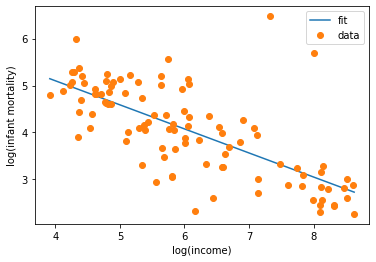

In [82]:
idx_order = np.argsort(log_income)  # needed for plotting the fit line
plt.plot(log_income[idx_order], posterior_mu[idx_order], label='fit')
plt.plot(log_income, log_infant, 'o', label='data')
plt.xlabel('log(income)')
plt.ylabel('log(infant mortality)')
plt.legend();

In [88]:
residules = log_infant - y_hat

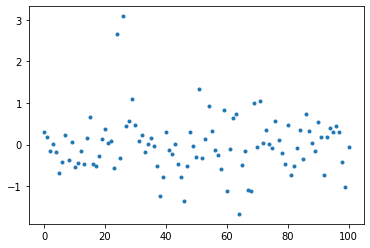

In [89]:
plt.plot(residules, '.');

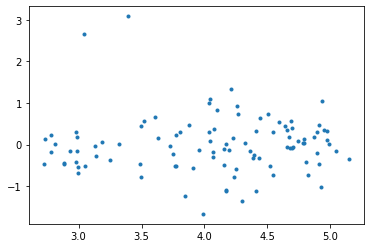

In [92]:
plt.plot(y_hat, residules, '.');

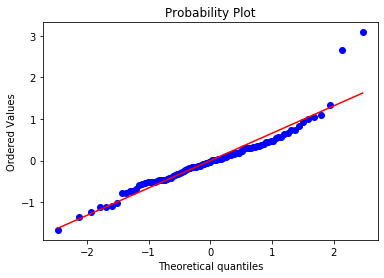

In [94]:
import scipy.stats as stats

stats.probplot(residules, dist="norm", plot=plt);